In [1]:
from wordcloud import WordCloud
from scipy.misc import imread
from pyspark.sql.functions import substring
from pyspark.sql.functions import length

In [2]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

import pandas as pd
import os
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import unix_timestamp, from_unixtime
import pyspark.sql.functions as f
from pyspark import SparkConf, SparkContext
from pyspark.sql.functions import concat, col, lit
import matplotlib.pyplot as plt

sc.version

'2.1.1'

In [3]:
# df = spark.read.csv('./datasets/NationalNames.csv', header = True)
df = spark.read.csv('./datasets/StateNames.csv', header = True)

In [4]:
df.printSchema()
df.take(3)

root
 |-- Id: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Year: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Count: string (nullable = true)



[Row(Id='1', Name='Mary', Year='1910', Gender='F', State='AK', Count='14'),
 Row(Id='2', Name='Annie', Year='1910', Gender='F', State='AK', Count='12'),
 Row(Id='3', Name='Anna', Year='1910', Gender='F', State='AK', Count='10')]

In [5]:
# count string --> integer
df = df.withColumn("Count", df["Count"].cast(IntegerType()))
df = df.withColumn("Year", df["Year"].cast(IntegerType()))
df = df.withColumn("start_char", substring(df.Name, 1, 1))
df = df.withColumn("len", length("Name"))
df.printSchema()
df.take(3)

root
 |-- Id: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Count: integer (nullable = true)
 |-- start_char: string (nullable = true)
 |-- len: integer (nullable = true)



[Row(Id='1', Name='Mary', Year=1910, Gender='F', State='AK', Count=14, start_char='M', len=4),
 Row(Id='2', Name='Annie', Year=1910, Gender='F', State='AK', Count=12, start_char='A', len=5),
 Row(Id='3', Name='Anna', Year=1910, Gender='F', State='AK', Count=10, start_char='A', len=4)]

In [6]:
df.count()

5647426

In [7]:
tmp = df.agg({"Count":"sum"}).collect()
total_num_baby = tmp[0]['sum(Count)']

tmp = df.filter(df.Gender == 'F').agg({"Count":"sum"}).collect()
total_num_girls = tmp[0]['sum(Count)']

tmp = df.filter(df.Gender == 'M').agg({"Count":"sum"}).collect()
total_num_boys = tmp[0]['sum(Count)']

print(total_num_baby, total_num_boys, total_num_girls)

298883326 155113251 143770075


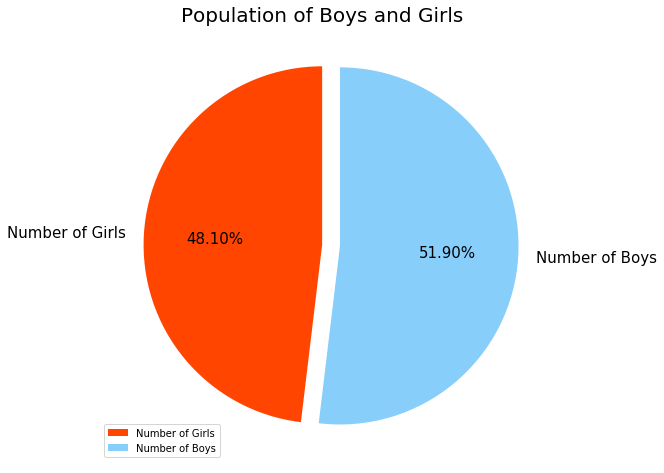

In [8]:
# 男女比例图
labels = ['Number of Girls', 'Number of Boys']
size1 = [total_num_girls, total_num_boys]

explode = (0, 0.1)
colors = ['orangered', 'lightskyblue']

f = plt.figure(figsize=(8, 8))
ax1 = f.add_subplot(111)
plt.axis('equal')
patches, text1, text2 = ax1.pie(
    size1,
    labels = labels,
    autopct = '%3.2f%%',
    shadow = False,
    startangle = 90,
    pctdistance = 0.6,
    explode = explode,
    colors = colors
)

for t in text1:
    t.set_size(15)
for t in text2:
    t.set_size(15)
plt.title('Population of Boys and Girls', fontsize=20)
plt.legend(loc = 'lower left')
plt.show()

In [9]:
# 男女数量，不同年份对比
years = range(1910, 2015, 1)

boy_num_year = df.filter(df.Gender == 'M') \
                 .groupby("Year") \
                 .agg({"Count":"sum"}) \
                 .sort("Year") \
                 .collect()


In [10]:
girl_num_year = df.filter(df.Gender == 'F') \
                  .groupby("Year") \
                  .agg({"Count":"sum"}) \
                  .sort("Year") \
                  .collect()

In [11]:
boy_number_year_count = []
girl_number_year_count = []
for x in boy_num_year:
    boy_number_year_count.append(x[1])
for x in girl_num_year:
    girl_number_year_count.append(x[1])

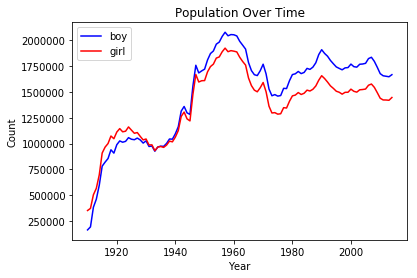

In [12]:
plt.plot(years, boy_number_year_count, color='blue', label='boy')
plt.plot(years, girl_number_year_count, color='red', label='girl')

plt.title('Population Over Time')
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend()
plt.show()

In [13]:
# 名字出现的频率 高->低
name_frequency = df.groupby("Name") \
                   .agg({"Count":"sum"}) \
                   .sort("sum(Count)", ascending=0) \
                   .collect()

In [14]:
# create word frequency dictionary
name_frequence_dic = {}

for x in name_frequency:
    if x[0] not in name_frequence_dic:
        name_frequence_dic[x[0]] = x[1]

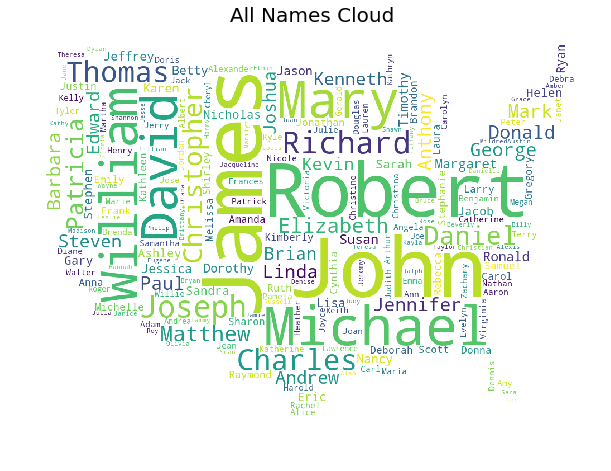

In [15]:
# word cloud
bg_path = imread('./images/usbg.jpg')
wc = WordCloud(
              background_color='white',
              mask=bg_path,
              max_font_size=150,
)


wc.generate_from_frequencies(name_frequence_dic)

plt.figure(figsize=(10, 10))
plt.imshow(wc)
plt.axis('off')
plt.title("All Names Cloud", fontsize=20)
plt.show()

In [16]:
names = []
number = []
frequency = []

i = 1
for x in name_frequency:
    if i > 20:
        break
    names.append(x[0])
    number.append(x[1])
    frequency.append(x[1] / total_num_baby)

    i += 1
names = names[::-1]
number = number[::-1]
frequency = frequency[::-1]
    
# print(names)
# print(number)
# print(frequency)

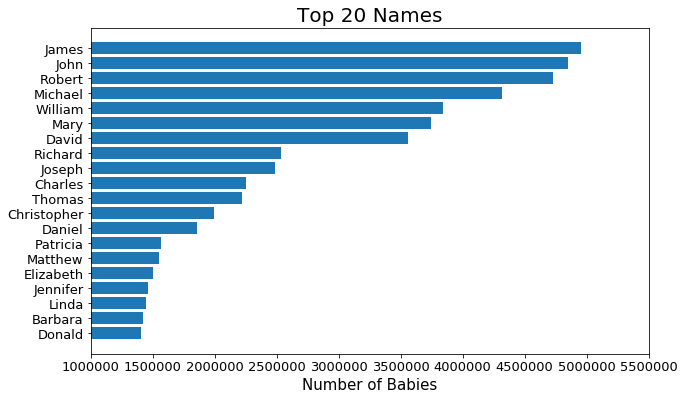

In [17]:
fig = plt.figure()
fig.set_size_inches(10, 6, forward=True)
ax = plt.subplot(111)
ax.set_xlim([1000000, 5500000])

ax.barh(range(len(names)), number, tick_label=names)
plt.title('Top 20 Names', fontsize=20)
plt.xlabel('Number of Babies', fontsize=15)
plt.tick_params(axis='both', labelsize=13)
plt.show()

In [18]:
# 名字为James的孩子占所有孩子的百分比
james_frequency = number[19] / total_num_baby
print(james_frequency)

frequency_top_20 = sum(frequency)
print(frequency_top_20)

0.016585622444525393
0.17965222991395643


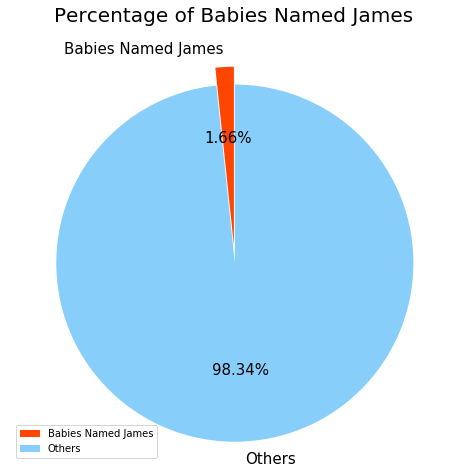

In [19]:
james_number = number[19]
top_20_number = sum(number)
# print(james_number)
# print(top_20_number)

labels = ['Babies Named James', 'Others']
size1 = [james_number, total_num_baby-james_number]

explode = (0, 0.1)
colors = ['orangered', 'lightskyblue']

f = plt.figure(figsize=(8, 8))
ax1 = f.add_subplot(111)
plt.axis('equal')
patches, text1, text2 = ax1.pie(
    size1,
    labels = labels,
    autopct = '%3.2f%%',
    shadow = False,
    startangle = 90,
    pctdistance = 0.6,
    explode = explode,
    colors = colors
)

for t in text1:
    t.set_size(15)
for t in text2:
    t.set_size(15)
plt.title('Percentage of Babies Named James', fontsize=20)
plt.legend(loc = 'lower left')
plt.show()

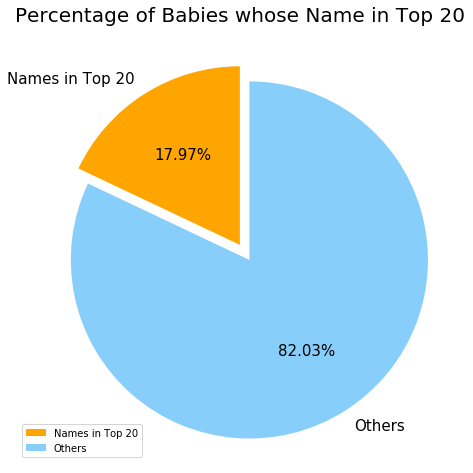

In [20]:
top_20_number = sum(number)
# print(james_number)
# print(top_20_number)

labels = ['Names in Top 20', 'Others']
size1 = [top_20_number, total_num_baby-top_20_number]

explode = (0, 0.1)
colors = ['orange', 'lightskyblue']

f = plt.figure(figsize=(8, 8))
ax1 = f.add_subplot(111)
plt.axis('equal')
patches, text1, text2 = ax1.pie(
                               size1,
                               labels = labels,
                               autopct = '%3.2f%%',
                               shadow = False,
                               startangle = 90,
                               pctdistance = 0.6,
                               explode = explode,
                               colors = colors
)

for t in text1:
    t.set_size(15)
for t in text2:
    t.set_size(15)
plt.title('Percentage of Babies whose Name in Top 20', fontsize=20)
plt.legend(loc = 'lower left')
plt.show()

In [21]:
# 前五名名称的逐年趋势图
top_5_names = names[-5:][::-1]
# years = range(1880, 2015, 1)



In [22]:
# 前五名名称的逐年趋势图
# james_trend = df.filter(df.Name == "James").groupby("Year").agg({"Count":"sum"}).sort("Year").collect()

In [23]:
top_5_data_year = {}
for name in top_5_names:
    tmp_name = df.filter(df.Name == name) \
                 .groupby("Year") \
                 .agg({"Count":"sum"}) \
                 .sort("Year") \
                 .collect()
    data = []
    for x in tmp_name:
        data.append(x['sum(Count)'])
    top_5_data_year[name] = data

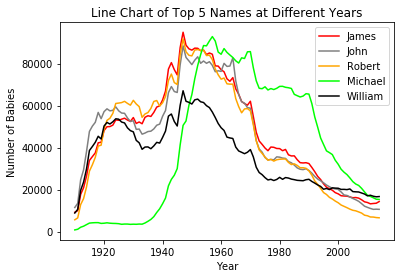

In [24]:
colors = ['red', 'gray', 'orange', 'lime', 'black']
for i in range(5):
    plt.plot(years, top_5_data_year[top_5_names[i]], color=colors[i], label=top_5_names[i])

plt.title('Line Chart of Top 5 Names at Different Years')
plt.xlabel('Year')
plt.ylabel('Number of Babies')
plt.legend()
plt.show()

In [25]:
# 男孩儿、女孩儿名字排行前20名
boy_frequency = df.filter(df.Gender =='M') \
                   .groupby("Name") \
                   .agg({"Count":"sum"}) \
                   .sort("sum(Count)", ascending=0) \
                   .collect()

In [26]:
names = []
number = []
frequency = []

i = 1
for x in boy_frequency:
    if i > 20:
        break
    names.append(x[0])
    number.append(x[1])
    frequency.append(x[1] / total_num_baby)

    i += 1
names = names[::-1]
number = number[::-1]
frequency = frequency[::-1]

# print(names)
# print(number)

boy_james_number = number[-1]
print(boy_james_number)

4938965


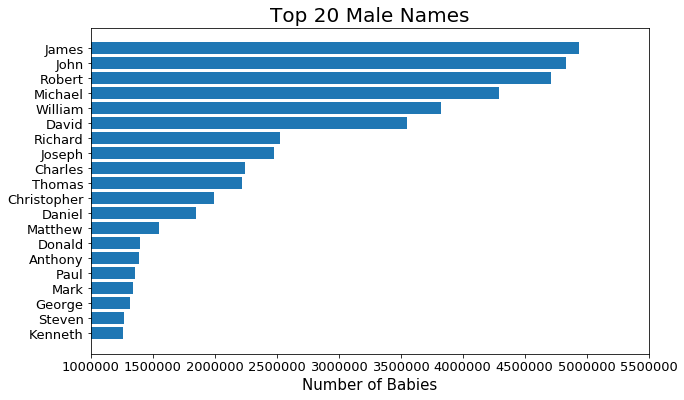

In [27]:
fig = plt.figure()
fig.set_size_inches(10, 6, forward=True)
ax = plt.subplot(111)
ax.set_xlim([1000000, 5500000])

ax.barh(range(len(names)), number, tick_label=names)
plt.title('Top 20 Male Names', fontsize=20)
plt.xlabel('Number of Babies', fontsize=15)
plt.tick_params(axis='both', labelsize=13)
plt.show()

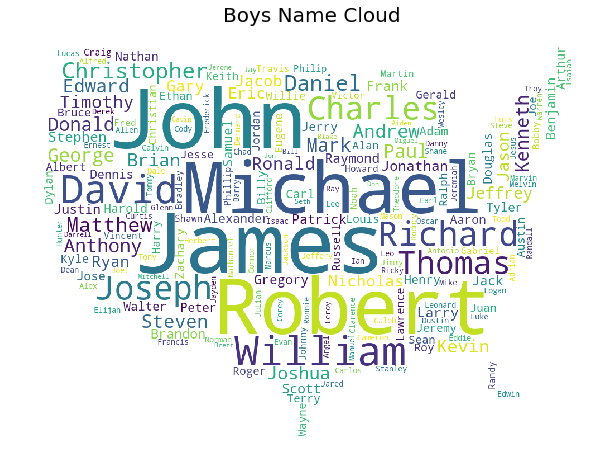

In [28]:
name_frequence_dic = {}

for x in boy_frequency:
    if x[0] not in name_frequence_dic:
        name_frequence_dic[x[0]] = x[1]

bg_path = imread('./images/usbg.jpg')
wc = WordCloud(
              background_color='white',
              mask=bg_path,
              max_font_size=150,
)


wc.generate_from_frequencies(name_frequence_dic)

plt.figure(figsize=(10, 10))
plt.imshow(wc)
plt.axis('off')
plt.title("Boys Name Cloud", fontsize=20)
plt.show()

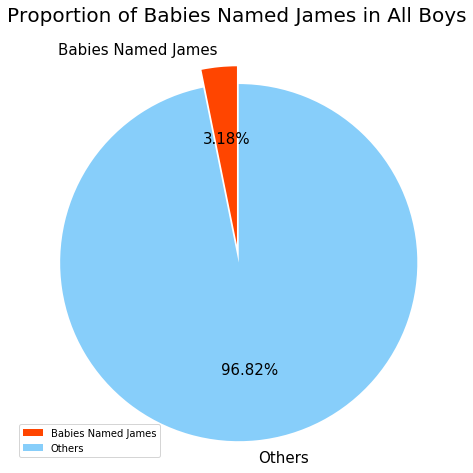

In [29]:
# 男名字第一名占据所有男性的比例

labels = ['Babies Named James', 'Others']
size1 = [boy_james_number, total_num_boys-boy_james_number]

explode = (0, 0.1)
colors = ['orangered', 'lightskyblue']

f = plt.figure(figsize=(8, 8))
ax1 = f.add_subplot(111)
plt.axis('equal')
patches, text1, text2 = ax1.pie(
    size1,
    labels = labels,
    autopct = '%3.2f%%',
    shadow = False,
    startangle = 90,
    pctdistance = 0.6,
    explode = explode,
    colors = colors
)

for t in text1:
    t.set_size(15)
for t in text2:
    t.set_size(15)
plt.title('Proportion of Babies Named James in All Boys', fontsize=20)
plt.legend(loc = 'lower left')
plt.show()

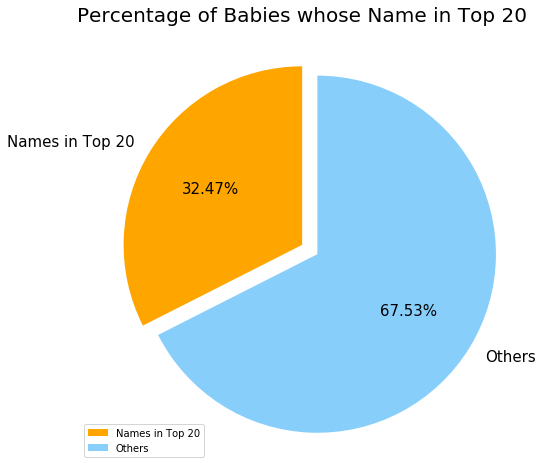

In [30]:
top_20_number = sum(number)

labels = ['Names in Top 20', 'Others']
size1 = [top_20_number, total_num_boys-top_20_number]

explode = (0, 0.1)
colors = ['orange', 'lightskyblue']

f = plt.figure(figsize=(8, 8))
ax1 = f.add_subplot(111)
plt.axis('equal')
patches, text1, text2 = ax1.pie(
                               size1,
                               labels = labels,
                               autopct = '%3.2f%%',
                               shadow = False,
                               startangle = 90,
                               pctdistance = 0.6,
                               explode = explode,
                               colors = colors
)

for t in text1:
    t.set_size(15)
for t in text2:
    t.set_size(15)
plt.title('Percentage of Babies whose Name in Top 20', fontsize=20)
plt.legend(loc = 'lower left')
plt.show()

In [31]:
girl_frequency = df.filter(df.Gender =='F') \
                   .groupby("Name") \
                   .agg({"Count":"sum"}) \
                   .sort("sum(Count)", ascending=0) \
                   .collect()

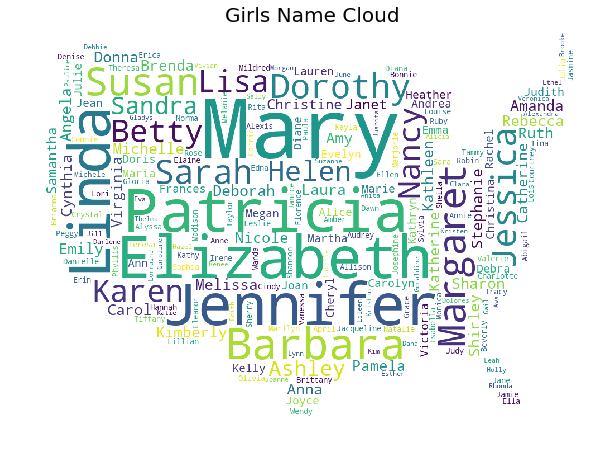

In [32]:
name_frequence_dic = {}

for x in girl_frequency:
    if x[0] not in name_frequence_dic:
        name_frequence_dic[x[0]] = x[1]

bg_path = imread('./images/usbg.jpg')
wc = WordCloud(
              background_color='white',
              mask=bg_path,
              max_font_size=150,
)


wc.generate_from_frequencies(name_frequence_dic)

plt.figure(figsize=(10, 10))
plt.imshow(wc)
plt.axis('off')
plt.title("Girls Name Cloud", fontsize=20)
plt.show()

In [33]:
names = []
number = []
frequency = []

i = 1
for x in girl_frequency:
    if i > 20:
        break
    names.append(x[0])
    number.append(x[1])
    frequency.append(x[1] / total_num_baby)

    i += 1
names = names[::-1]
number = number[::-1]
frequency = frequency[::-1]

girl_mary_number = number[-1]
print(girl_mary_number)

3730856


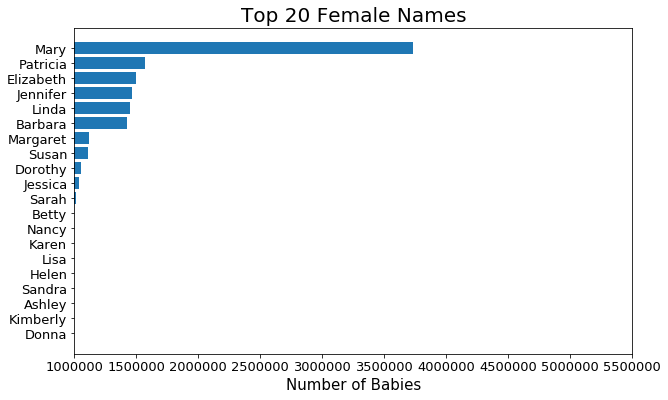

In [34]:
fig = plt.figure()
fig.set_size_inches(10, 6, forward=True)
ax = plt.subplot(111)
ax.set_xlim([1000000, 5500000])

ax.barh(range(len(names)), number, tick_label=names)
plt.title('Top 20 Female Names', fontsize=20)
plt.xlabel('Number of Babies', fontsize=15)
plt.tick_params(axis='both', labelsize=13)
plt.show()

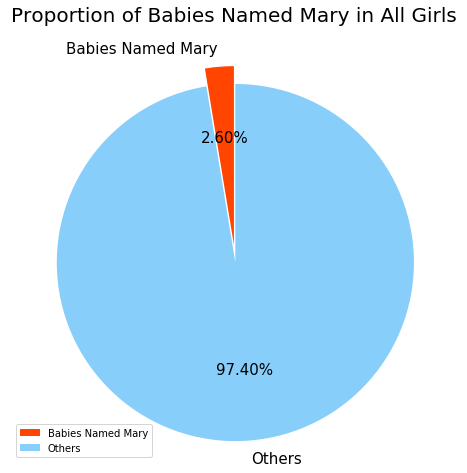

In [35]:
# 女孩名字第一名占据所有女性的比例

labels = ['Babies Named Mary', 'Others']
size1 = [girl_mary_number, total_num_girls-girl_mary_number]

explode = (0, 0.1)
colors = ['orangered', 'lightskyblue']

f = plt.figure(figsize=(8, 8))
ax1 = f.add_subplot(111)
plt.axis('equal')
patches, text1, text2 = ax1.pie(
    size1,
    labels = labels,
    autopct = '%3.2f%%',
    shadow = False,
    startangle = 90,
    pctdistance = 0.6,
    explode = explode,
    colors = colors
)

for t in text1:
    t.set_size(15)
for t in text2:
    t.set_size(15)
plt.title('Proportion of Babies Named Mary in All Girls', fontsize=20)
plt.legend(loc = 'lower left')
plt.show()

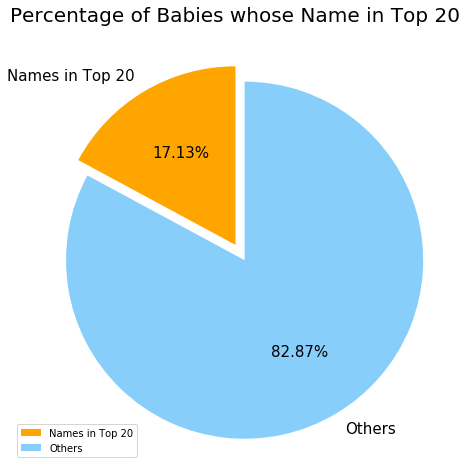

In [36]:
top_20_number = sum(number)

labels = ['Names in Top 20', 'Others']
size1 = [top_20_number, total_num_girls-top_20_number]

explode = (0, 0.1)
colors = ['orange', 'lightskyblue']

f = plt.figure(figsize=(8, 8))
ax1 = f.add_subplot(111)
plt.axis('equal')
patches, text1, text2 = ax1.pie(
                               size1,
                               labels = labels,
                               autopct = '%3.2f%%',
                               shadow = False,
                               startangle = 90,
                               pctdistance = 0.6,
                               explode = explode,
                               colors = colors
)

for t in text1:
    t.set_size(15)
for t in text2:
    t.set_size(15)
plt.title('Percentage of Babies whose Name in Top 20', fontsize=20)
plt.legend(loc = 'lower left')
plt.show()

In [37]:
# # intersection = boy_frequency.select('Name').intersect(girl_frequency.select('Name'))
# boy_frequency = df.filter(df.Gender =='M') \
#                    .groupby("Name") \
#                    .agg({"Count":"sum"}) \
#                    .sort("sum(Count)", ascending=0)
            
# girl_frequency = df.filter(df.Gender =='F') \
#                    .groupby("Name") \
#                    .agg({"Count":"sum"}) \
#                    .sort("sum(Count)", ascending=0)



In [38]:
# intersection = boy_frequency.select("Name", "sum(Count)") \
#                             .intersect(girl_frequency.select("Name", "sum(Count)")) \
#                             .sort("sum(Count)", ascending=0) \
#                             .collect()

In [39]:
# intersection_name = []
# intersection_num = []
# for x in intersection:
#     intersection_name.append(x[0])
#     intersection_num.append(x[1] * 2)
# print(intersection_name, intersection_num)

# # 男女共用名字的宝宝数量
# intersection_total_num = sum(intersection_num)
# print(intersection_total_num)

# intersection_name = intersection_name[:19]
# intersection_num = intersection_num[:19]


In [40]:
# fig = plt.figure()
# fig.set_size_inches(10, 6, forward=True)
# ax = plt.subplot(111)
# ax.set_xlim([0, 200])

# ax.barh(range(len(names)), intersection_num, tick_label=intersection_name)
# plt.title('Top 20 Gender Neutral Names', fontsize=20)
# plt.xlabel('Number of Babies', fontsize=15)
# plt.tick_params(axis='both', labelsize=13)
# plt.show()

In [41]:
# df.filter(df.Name == 'James').filter(df.Gender == 'F').show()

In [42]:
start_charactor_boy = df.filter(df.Gender =='M') \
                        .groupby("start_char") \
                        .agg({"Count":"sum"}) \
                        .sort("start_char") \
                        .collect()

In [43]:
# bar chart
charactor = []
charactor_count_boy = []
for x in start_charactor_boy:
    charactor.append(x[0])
    charactor_count_boy.append(x[1])
print(charactor)
print(charactor_count_boy)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
[10073054, 7140823, 11245004, 13068742, 6116761, 2591575, 5866561, 3243232, 1091769, 27239116, 4885534, 5551268, 11584336, 2907809, 780452, 3850636, 123209, 15208120, 6756880, 7467520, 55268, 975237, 6324157, 140401, 76319, 749468]


In [44]:
start_charactor_girl = df.filter(df.Gender =='F') \
                         .groupby("start_char") \
                         .agg({"Count":"sum"}) \
                         .sort("start_char") \
                         .collect()

In [45]:
charactor_count_girl = []
for x in start_charactor_girl:
    charactor_count_girl.append(x[1])
print(charactor)
print(charactor_count_girl)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
[13744632, 7458113, 10800098, 8458767, 7828823, 1572309, 3329445, 3518323, 1460317, 13198104, 9481823, 9956757, 16683354, 3530713, 670953, 4539434, 34938, 5993559, 11758497, 4863584, 25629, 3006509, 1035365, 30108, 509283, 280638]


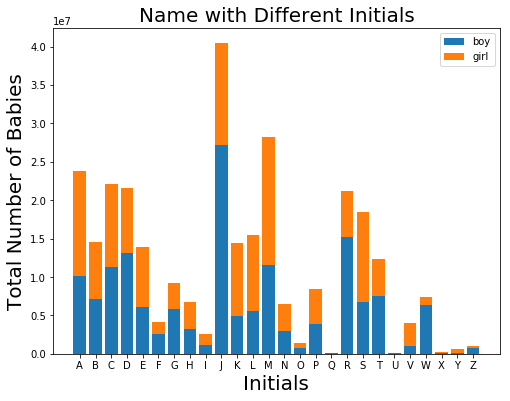

In [46]:
plt.figure(figsize=(8,6))
plt.bar(range(len(charactor)), charactor_count_boy, label='boy')
plt.bar(range(len(charactor)), charactor_count_girl, bottom=charactor_count_boy, 
        label='girl', tick_label=charactor)
plt.legend()
plt.title("Name with Different Initials", fontsize=20)
plt.xlabel("Initials", fontsize=20)
plt.ylabel("Total Number of Babies", fontsize=20)

plt.show()

In [47]:
length_name_boy = df.filter(df.Gender =='M') \
                .groupby("len") \
                .agg({"Count":"sum"}) \
                .sort("len") \
                .collect()

In [48]:
name_len = []
name_len_count_boy = []
for x in length_name_boy:
    name_len.append(x[0])
    name_len_count_boy.append(x[1])

print(name_len)
print(name_len_count_boy)
print(len(name_len_count_boy))

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[79775, 3682800, 23543117, 38911129, 43894434, 34438686, 5944478, 2474931, 121961, 2018387, 2532, 700, 247, 74]
14


In [49]:
length_name_girl = df.filter(df.Gender =='F') \
                .groupby("len") \
                .agg({"Count":"sum"}) \
                .sort("len") \
                .collect()

In [50]:
name_len_count_girl = []
for x in length_name_girl:
    name_len_count_girl.append(x[1])

print(name_len_count_girl)
print(len(name_len_count_girl))

[182445, 3427090, 18549419, 36615645, 32987039, 28384595, 15096103, 7680242, 832371, 12713, 662, 1039, 707, 5]
14


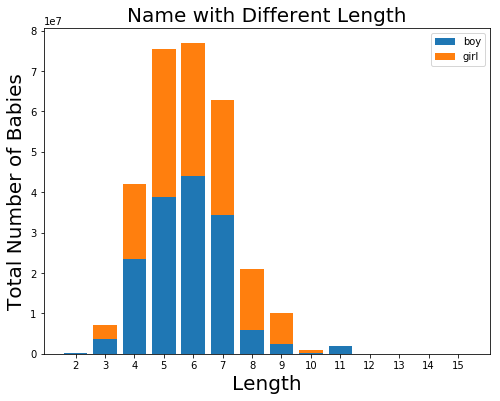

In [51]:
plt.figure(figsize=(8,6))
plt.bar(range(len(name_len)), name_len_count_boy, label='boy')
plt.bar(range(len(name_len)), name_len_count_girl, bottom=name_len_count_boy, 
        label='girl', tick_label=name_len)
plt.legend()
plt.title("Name with Different Length", fontsize=20)
plt.xlabel("Length", fontsize=20)
plt.ylabel("Total Number of Babies", fontsize=20)

plt.show()

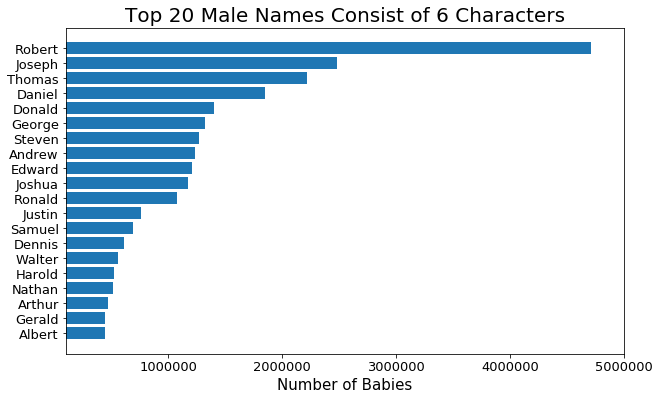

In [52]:
length_6_boy = df.filter(df.Gender =='M') \
                .filter(df.len == 6) \
                .groupby("Name") \
                .agg({"Count":"sum"}) \
                .sort("sum(Count)", ascending=0) \
                .collect()           
                
names = []
number = []

i = 1
for x in length_6_boy:
    if i > 20:
        break
    names.append(x[0])
    number.append(x[1])

    i += 1
names = names[::-1]
number = number[::-1]

fig = plt.figure()
fig.set_size_inches(10, 6, forward=True)
ax = plt.subplot(111)
ax.set_xlim([100000, 5000000])

ax.barh(range(len(names)), number, tick_label=names)
plt.title('Top 20 Male Names Consist of 6 Characters', fontsize=20)
plt.xlabel('Number of Babies', fontsize=15)
plt.tick_params(axis='both', labelsize=13)
plt.show()

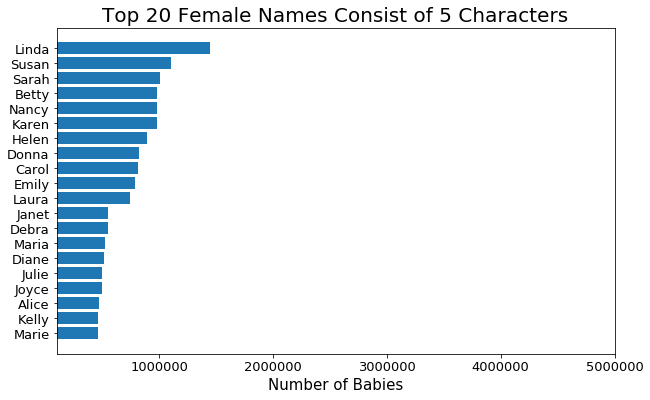

In [53]:
length_5_girl = df.filter(df.Gender =='F') \
                .filter(df.len == 5) \
                .groupby("Name") \
                .agg({"Count":"sum"}) \
                .sort("sum(Count)", ascending=0) \
                .collect()           
                
names = []
number = []

i = 1
for x in length_5_girl:
    if i > 20:
        break
    names.append(x[0])
    number.append(x[1])

    i += 1
names = names[::-1]
number = number[::-1]

fig = plt.figure()
fig.set_size_inches(10, 6, forward=True)
ax = plt.subplot(111)
ax.set_xlim([100000, 5000000])

ax.barh(range(len(names)), number, tick_label=names)
plt.title('Top 20 Female Names Consist of 5 Characters', fontsize=20)
plt.xlabel('Number of Babies', fontsize=15)
plt.tick_params(axis='both', labelsize=13)
plt.show()

In [54]:
# 不同state名字的数量（那个州的人最喜欢给孩子起名字）
                
state_names = df.select(df.Name, df.State)

In [55]:
state_names.take(3)

[Row(Name='Mary', State='AK'),
 Row(Name='Annie', State='AK'),
 Row(Name='Anna', State='AK')]

In [56]:
state_names.distinct().groupby("State").count().sort("count", ascending=0).collect()

[Row(State='CA', count=18735),
 Row(State='TX', count=16464),
 Row(State='NY', count=13933),
 Row(State='IL', count=10710),
 Row(State='FL', count=10605),
 Row(State='GA', count=9344),
 Row(State='OH', count=8951),
 Row(State='PA', count=8742),
 Row(State='NC', count=8492),
 Row(State='MI', count=8469),
 Row(State='NJ', count=7326),
 Row(State='VA', count=6989),
 Row(State='LA', count=6858),
 Row(State='TN', count=6658),
 Row(State='AL', count=6410),
 Row(State='IN', count=6281),
 Row(State='MO', count=6225),
 Row(State='WA', count=5828),
 Row(State='SC', count=5563),
 Row(State='OK', count=5462),
 Row(State='MS', count=5430),
 Row(State='AZ', count=5410),
 Row(State='MD', count=5385),
 Row(State='WI', count=5300),
 Row(State='MN', count=5287),
 Row(State='MA', count=5128),
 Row(State='KY', count=5099),
 Row(State='CO', count=4873),
 Row(State='AR', count=4772),
 Row(State='UT', count=4419),
 Row(State='KS', count=4279),
 Row(State='IA', count=4201),
 Row(State='OR', count=4091),
 Row(

In [57]:
# 哪个州的James最多
state_james = df.filter(df.Name == "James") \
                .groupby("State") \
                .agg({"Count":"sum"}) \
                .sort("sum(Count)", ascending=0) \
                .collect()
print(len(state_james))
# for x in state_james:
#     print(x)

51


In [58]:
# 哪个州的Mary最多
state_mary = df.filter(df.Name == "Mary") \
                .groupby("State") \
                .agg({"Count":"sum"}) \
                .sort("sum(Count)", ascending=0) \
                .collect()

print(len(state_mary))
# for x in state_mary:
#     print(x)

51
